In [17]:
import socket
import numpy as np
import matplotlib.pyplot as plt
import math as m
import pandas as pd

IP = '127.0.0.1'
PORT = 4242
HANDSHAKE = 'READY'

# ? Create socket
sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM, socket.IPPROTO_UDP)
sock.settimeout(1)

data = ''

while (data == ''):
	try:
		sock.sendto(HANDSHAKE.encode('UTF-8'), (IP, PORT))
		data, addr = sock.recvfrom(1024)
		data = data.decode('UTF-8')
	except:
		pass

print('HANDSHAKE SENT')

HANDSHAKE SENT


In [18]:
def parse(data):
	# ? Skip garbage, print graphs and store data if we get a timeout
	while (data != 'MSG_START'):
		try:
			data, addr = sock.recvfrom(1024)
			data = data.decode('UTF-8')
		except:
			fig = plt.figure(figsize=(18,18))
			ax = fig.add_subplot(111, projection='3d')
			ax.plot3D(HIST_X, HIST_Y, HIST_Z, 'Green')
			plt.show()
			pd.DataFrame(HIST_X).to_csv("X.csv")
			pd.DataFrame(HIST_Y).to_csv("Y.csv")
			pd.DataFrame(HIST_Z).to_csv("Z.csv")
			raise KeyboardInterrupt()
			data, addr = sock.recvfrom(1024)
			data = data.decode('UTF-8')

	posX = 0.0
	posY = 0.0
	posZ = 0.0
	s = 0.0
	aX = 0.0
	aY = 0.0
	aZ = 0.0
	dX = 0.0
	dY = 0.0
	dZ = 0.0
	POS_UPDATE = False

	# ? Parse position
	data, addr = sock.recvfrom(1024)
	data = data.decode('UTF-8')
	if (data.find('POSITION') != -1):
		dt = data[data.find('\n')+1:]
		posX = dt[:dt.find('\n')]
		dt = dt[dt.find('\n')+1:]
		posY = dt[:dt.find('\n')]
		dt = dt[dt.find('\n')+1:]
		posZ = dt[:dt.find('\n')]
		# print('posX: ', posX)
		# print('posY: ', posY)
		# print('posZ: ', posZ)
		POS_UPDATE = True
		data, addr = sock.recvfrom(1024)
		data = data.decode('UTF-8')

	# ? Parse Speed
	if (data.find('SPEED') != -1):
		dt = data[data.find('\n')+1:]
		s = dt[:dt.find('\n')]
		# print('Speed: ', s)
		data, addr = sock.recvfrom(1024)
		data = data.decode('UTF-8')

	# ? Parse Acceleration
	if (data.find('ACCELERATION') != -1):
		dt = data[data.find('\n')+1:]
		aX = dt[:dt.find('\n')]
		dt = dt[dt.find('\n')+1:]
		aY = dt[:dt.find('\n')]
		dt = dt[dt.find('\n')+1:]
		aZ = dt[:dt.find('\n')]
		# print('aX: ', aX)
		# print('aY: ', aY)
		# print('aZ: ', aZ)
		data, addr = sock.recvfrom(1024)
		data = data.decode('UTF-8')

	# ? Parse Direction
	if (data.find('DIRECTION') != -1):
		dt = data[data.find('\n')+1:]
		dX = dt[:dt.find('\n')]
		dt = dt[dt.find('\n')+1:]
		dY = dt[:dt.find('\n')]
		dt = dt[dt.find('\n')+1:]
		dZ = dt[:dt.find('\n')]
		# print('dX: ', dX)
		# print('dY: ', dY)
		# print('dZ: ', dZ)

	return posX, posY, posZ, s, aX, aY, aZ, dX, dY, dZ, POS_UPDATE

In [19]:
def Rx(phi):
	return np.matrix([
						[ 1, 0         , 0         ],
						[ 0, m.cos(phi),-m.sin(phi)],
						[ 0, m.sin(phi), m.cos(phi)]
					])

def Ry(theta):
	return np.matrix([
						[ m.cos(theta), 0, m.sin(theta)],
						[ 0           , 1, 0           ],
						[-m.sin(theta), 0, m.cos(theta)]])

def Rz(psi):
	return np.matrix([
						[ m.cos(psi), -m.sin(psi), 0 ],
						[ m.sin(psi), m.cos(psi) , 0 ],
						[ 0         , 0          , 1 ]
					])

def FromEuler(psi, theta, phi):
	return np.asarray(Rz(psi) * Ry(theta) * Rx(phi)).astype('float32')

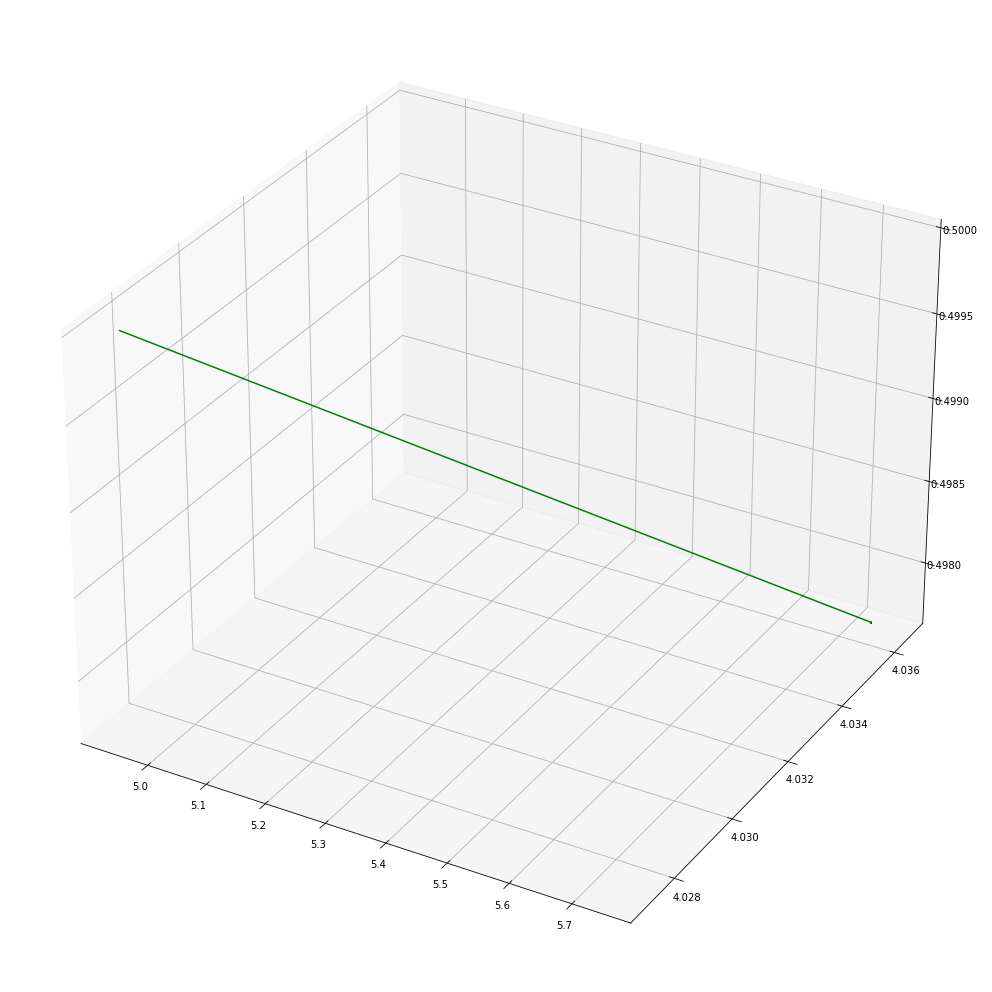

KeyboardInterrupt: 

In [20]:

# ? Initialize variables

# ? Position history
HIST_X = np.zeros(0)
HIST_Y = np.zeros(0)
HIST_Z = np.zeros(0)

# ? Initial speed
s = 0.0

# ? Initial noise correction
NOISE_CORR = [
				[0],
				[0],
				[0]
			]
NOISE_CORR = np.array(NOISE_CORR)

# ? Frequency of true position updating, 1 time every 300 estimations (true position is updated once every 3 sec and we make 1 estimation per 1/100th of a second)
UPDATE_RATE = 1 / 300

# ? Coefficient ofcorrection
COEF = 0.1

# ? Position has been updated ?
POS_UPDATE = False

# ? Initial position
P = [
		[0],
		[0],
		[0]
	]
P = np.asarray(P).astype('float64')

# ? Time interval between each prediction (in second)
t = 0.01

# TODO Find a way to correct the cofficient applied to MSE
# TODO Maybe correct speed by GPS true position if I find a way

# ? Main loop
while (True):

	# ? Receive and parse data
	posX, posY, posZ, s, aX, aY, aZ, dX, dY, dZ, POS_UPDATE = parse(data)

	# ? Get true position given by GPS
	if (POS_UPDATE == True):
		B = [
				[posX],
				[posY],
				[posZ]
			]
		# FIXME Calculate NOISE_CORR and make it negative (compensate error)
		B = np.asarray(B).astype('float64')
		E = np.subtract(B, P)

		# ? Update position with true position given by GPS
		P = B

	# ? Acceleration
	A = [
			[aX],
			[aY],
			[aZ]
		]
	A = np.asarray(A).astype('float64')

	# ? Direction as a rotation matrix
	D = [
			[dX],
			[dY],
			[dZ]
		]
	D = np.asarray(D).astype('float64')
	# FIXME Give correct rotation (maybe bad order atm)
	D = FromEuler(D[0][0], D[1][0], D[2][0])

	# ? Velocity as if in X axis direction (Speed on X axis)
	S = np.array([
					[s],
					[0.0],
					[0.0]
				])
	S = S.astype('float64')

	# ? Velocity
	V = D.dot(S)

	# ? let be F be the estimated final position matrix
	# ? let NOISE_CORR be the correction of the additive noise caused by sensors incertainity
	# ? formula should be
	# ? F = P + V * t + 0.5 * A * t ** 2 + NOISE_CORR(P, s, D, A)

	# ? Getting an history of positions
	# TODO maybe add a way to know which value is given by GPS
	HIST_X = np.append(HIST_X, P[0][0])
	HIST_Y = np.append(HIST_Y, P[1][0])
	HIST_Z = np.append(HIST_Z, P[2][0])

	# ? Calculating final position
	F = P + V * t + 0.5 * A * t ** 2 - NOISE_CORR * UPDATE_RATE

	# ? Sending result
	POS = str(F[0][0]) + ' ' + str(F[1][0]) + ' ' + str(F[2][0])
	# print(' POS: ' + str(POS))

	# ? Updating variables
	DEP = np.subtract(F, P)
	s = np.linalg.norm(DEP) * 1/t
	# print("s: " + str(s))
	P = F

	# ? Send estimated position
	sock.sendto(POS.encode('UTF-8'), (IP, PORT))